In [1]:
import pandas as pd
import plotnine as p9

In [2]:
%matplotlib inline

In [3]:
times = list(range(15, 135, 15))

In [4]:
df = (
    pd.read_csv("commentdata.dat")
    .reset_index()
    .rename(columns={
        "index": "post_id",
        " amount of minutes the scores were hidden": "time_hidden",
        " 0:15 score": 15,
        " 0:30 score": 30,
        " 0:45 score": 45,
        " 1:00 score": 60,
        " 1:15 score": 75,
        " 1:30 score": 90,
        " 1:45 score": 105,
        " 2:00 score": 120,
    })
    .drop("#timestamp", axis=1)
)

df.head()

post_id  time_hidden  15  30  45  60  75  90  105  120
0        0            0   1   1   1   1   1   1    1    1
1        1            0   2   2   2   2   2   2    1    1
2        2            0   1   2   2   3   3   3    3    3
3        3            0   2   2   3   3   3   3    3    3
4        4            0   1   1   1   1   2   2    2    2

In [5]:
df = (
    df
    .melt(id_vars=["post_id", "time_hidden"], var_name="time", value_name="score")
    .sort_values(by=["post_id", "time"])
    .reset_index(drop=True)
)
df.head()

post_id  time_hidden time  score
0        0            0   15      1
1        0            0   30      1
2        0            0   45      1
3        0            0   60      1
4        0            0   75      1

In [6]:
score120 = df.loc[df["time"] == 120, ["post_id", "score"]]

def updown(score):
    if score > 1:
        return "up"
    if score < 1:
        return "down"
    return "flat"
score120["updown"] = score120["score"].map(updown)

df = df.merge(
    right=score120[["post_id", "updown"]],
    on="post_id",
    how="outer",
)

df.head(20)

post_id  time_hidden time  score updown
0         0            0   15      1   flat
1         0            0   30      1   flat
2         0            0   45      1   flat
3         0            0   60      1   flat
4         0            0   75      1   flat
5         0            0   90      1   flat
6         0            0  105      1   flat
7         0            0  120      1   flat
8         1            0   15      2   flat
9         1            0   30      2   flat
10        1            0   45      2   flat
11        1            0   60      2   flat
12        1            0   75      2   flat
13        1            0   90      2   flat
14        1            0  105      1   flat
15        1            0  120      1   flat
16        2            0   15      1     up
17        2            0   30      2     up
18        2            0   45      2     up
19        2            0   60      3     up

In [7]:
time_stats = (
    df[["time", "score"]]
    .groupby("time")
    .agg(mean=("score", "mean"), std=("score", "std"))
)
time_stats["upper"] = time_stats["mean"] + 3 * time_stats["std"]
time_stats["lower"] = time_stats["mean"] - 3 * time_stats["std"]

df = df.merge(
    right=time_stats,
    on="time",
    how="outer",
)

df["outlier"] = (df["score"] > df["upper"]) | (df["score"] < df["lower"])

df.head(20)

post_id  time_hidden time  score updown      mean       std    upper  \
0         0            0   15      1   flat  1.490254  1.939698  7.30935   
1         1            0   15      2   flat  1.490254  1.939698  7.30935   
2         2            0   15      1     up  1.490254  1.939698  7.30935   
3         3            0   15      2     up  1.490254  1.939698  7.30935   
4         4            0   15      1     up  1.490254  1.939698  7.30935   
5         5            0   15      1   down  1.490254  1.939698  7.30935   
6         6            0   15      1     up  1.490254  1.939698  7.30935   
7         7            0   15      2   flat  1.490254  1.939698  7.30935   
8         8            0   15      2     up  1.490254  1.939698  7.30935   
9         9            0   15      1   flat  1.490254  1.939698  7.30935   
10       10            0   15      1     up  1.490254  1.939698  7.30935   
11       11            0   15      1     up  1.490254  1.939698  7.30935   
12       12            0   15      1   flat  1.490254  1.939698  7.30935   
13       13            0   15      1     up  1.490254  1.939698  7.30935   
14       14            0   15      1   flat  1.490254  1.939698  7.30935   
15       15            0   15      1     up  1.490254  1.939698  7.30935   
16       16            0   15      1     up  1.490254  1.939698  7.30935   
17       17            0   15      1   flat  1.490254  1.939698  7.30935   
18       18            0   15      2     up  1.490254  1.939698  7.30935   
19       19            0   15      2     up  1.490254  1.939698  7.30935   

       lower  outlier  
0  -4.328841    False  
1  -4.328841    False  
2  -4.328841    False  
3  -4.328841    False  
4  -4.328841    False  
5  -4.328841    False  
6  -4.328841    False  
7  -4.328841    False  
8  -4.328841    False  
9  -4.328841    False  
10 -4.328841    False  
11 -4.328841    False  
12 -4.328841    False  
13 -4.328841    False  
14 -4.328841    False  
15 -4.328841    False  
16 -4.328841    False  
17 -4.328841    False  
18 -4.328841    False  
19 -4.328841    False

In [8]:
plot_data = (
    df.loc[df["updown"] != "flat", ["updown", "time", "time_hidden", "outlier"]]
    .groupby(["updown", "time", "time_hidden"])
    .mean()
    .reset_index()
)

plot_data["updown"] = pd.Categorical(plot_data["updown"].map({
    "up": "upvoted posts",
    "down": "downvoted posts",
    "flat": "flat posts",
}))

plot_data["time_hidden"] = pd.Categorical(plot_data["time_hidden"].map({
    0: "0 minutes",
    30: "30 minutes",
    60: "60 mintues",
}))

plot_data["outlier"] = 100 * plot_data["outlier"]

plot_data.head()

updown  time time_hidden   outlier
0  downvoted posts    15   0 minutes  3.944716
1  downvoted posts    15  30 minutes  2.395210
2  downvoted posts    15  60 mintues  1.469081
3  downvoted posts    30   0 minutes  3.224878
4  downvoted posts    30  30 minutes  1.953987

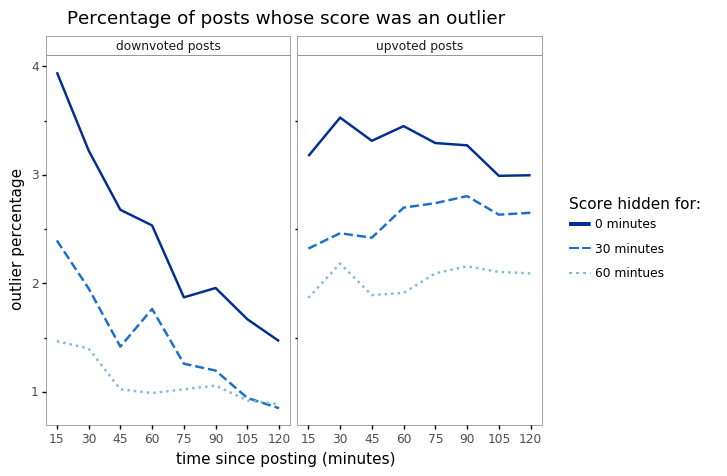

<ggplot: (-9223363254429546464)>

In [9]:
plot = (
    p9.ggplot(data=plot_data)
    + p9.aes(x="time", y="outlier", color="time_hidden", linetype="time_hidden")
    + p9.geom_line(size=1)
    + p9.scale_color_manual(["#022f8e", "#1c70c8", "#7dbcde"])
    + p9.scale_linetype_manual(["solid", "dashed", "dotted"])
    + p9.scale_x_continuous(breaks=times, minor_breaks=[])
    + p9.facet_wrap("updown", ncol=2)
    + p9.guides(
        color=p9.guide_legend(title="Score hidden for:"),
        linetype=p9.guide_legend(title="Score hidden for:"),
    )
    + p9.xlab("time since posting (minutes)")
    + p9.ylab("outlier percentage")
    + p9.ggtitle("Percentage of posts whose score was an outlier")
    + p9.theme_bw()
    + p9.theme(
        panel_grid_major=p9.element_blank(),
        panel_grid_minor=p9.element_blank(),
        strip_background=p9.element_rect(fill="#ffffff", size=0.5),
        legend_key=p9.element_rect(fill="#ffffff", color="#ffffff"),
        panel_border=p9.element_rect(size=0.5),
    )
)
plot

In [10]:
plot.save("outliers.png", width=8, height=4)

/home/rjmorris/apps/opt/pyenv/versions/3.7.3/envs/reddit-comments/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 8 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/rjmorris/apps/opt/pyenv/versions/3.7.3/envs/reddit-comments/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: outliers.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
